In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
from pathlib import Path
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import seaborn as sns
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cpu


In [40]:
def transform(img, epsilon=1e-8):
    # Convert the input image (Pandas DataFrame) to a torch tensor
    img_tensor = torch.tensor(img.values, dtype=torch.float32)
    
    # Add batch and channel dimensions for the CNN
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0)  # Shape becomes [1, 1, H, W]
    
    # Resize the image to the required size (5000, 20)
    img_resized = F.interpolate(img_tensor, size=(5000, 20), mode='bilinear', align_corners=False)
    
    # Normalize each column (feature) individually
    for i in range(img_resized.shape[2]):  # Iterate through the columns (features)
        column = img_resized[:, :, i, :]  # Extract each column
        mean = column.mean()
        std = column.std()
        
        # Prevent division by zero
        std = std + epsilon
        
        # Normalize the column (feature)
        img_resized[:, :, i, :] = (column - mean) / std
    
    return img_resized

In [41]:
from torch.utils.data import Dataset

class MusicDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [42]:
artists = ['Asha_Bhosle', 'Michael_Jackson', 'Kishore_Kumar', 'Indian_National_Anthem', 'Marathi_Bhavgeet', 'Marathi_Lavani']
num_classes = len(artists)

In [43]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, input_channels: int = 1, output_shape: int = num_classes):
        super(SimpleCNN, self).__init__()
        
        # Define more convolutional layers
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(0.3)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(0.3)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(0.3)
        )
        
        # Calculate the output size after convolutional layers
        self._dummy_input = torch.zeros(1, input_channels, 20, 5000)
        self._conv_out_size = self._get_conv_output(self._dummy_input)
        print("Calculated output size after conv layers:", self._conv_out_size)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self._conv_out_size, 512)
        self.fc2 = nn.Linear(512, output_shape)

    def _get_conv_output(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        return int(torch.prod(torch.tensor(x.size()[1:])))  # Flatten the dimensions

    def forward(self, x, extract_features=False):
        # Pass through convolutional blocks
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        
        # Flatten the output from the convolutional layers
        x = x.view(x.size(0), -1)
        
        # If we need to extract features, return after the first fully connected layer
        if extract_features:
            features = self.fc1(x)
            return features
        
        # Otherwise, continue to the final fully connected layer and return the output
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [44]:
X = []
for i in tqdm(range(1, 117)):
    song = pd.read_csv(f"MFCC_T/{i:02d}-MFCC.csv")
    X.append(transform(song))

  0%|          | 0/116 [00:00<?, ?it/s]

 20%|█▉        | 23/116 [00:13<00:54,  1.72it/s]


KeyboardInterrupt: 

In [ ]:
X1 = torch.stack(X)
X1 = X1.squeeze(1)
X1.shape


torch.Size([116, 1, 5000, 20])

In [ ]:
model = SimpleCNN(input_channels=1, output_shape=num_classes)
model.load_state_dict(torch.load("models/model_final.pth"))
model.eval()

Calculated output size after conv layers: 160000


SimpleCNN(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (fc1): Linear(in_features=160000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=6, bias=True)
)

In [ ]:
with torch.no_grad():
    pred_logits = model(X1)
    pred_probs = F.softmax(pred_logits, dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)

In [ ]:
artist_short = ['AB', 'MJ', 'KK', 'INA', 'MB', 'ML']

In [ ]:
# Print the header with artist names and aligned columns
header = f"{'Song Number':<12} | " + " | ".join([f"Prob {artist:<4}" for artist in artist_short]) + " | Predicted Artist"
print(header)
print("-" * len(header))  # Separator line

# Print each song's probabilities and predicted artist
for i in range(1, 117):
    # Format probabilities with 2 decimal places and percent sign
    probabilities = " | ".join([f"{pred_probs[i-1][j] * 100:8.2f}%" for j in range(6)])  
    predicted_artist = "    "+artist_short[pred_labels[i-1]]
    
    # Print the row with aligned columns
    print(f"{i:<12} | {probabilities} | {predicted_artist}")


Song Number  | Prob AB   | Prob MJ   | Prob KK   | Prob INA  | Prob MB   | Prob ML   | Predicted Artist
-------------------------------------------------------------------------------------------------------
1            |    20.25% |     3.10% |    28.27% |    40.32% |     3.93% |     4.13% |     INA
2            |    35.64% |     5.78% |     9.15% |    37.00% |     8.75% |     3.68% |     INA
3            |     0.21% |    99.61% |     0.02% |     0.08% |     0.00% |     0.07% |     MJ
4            |    92.03% |     0.00% |     0.01% |     0.01% |     7.82% |     0.13% |     AB
5            |    11.01% |     0.01% |    83.96% |     0.01% |     2.34% |     2.67% |     KK
6            |     0.10% |     0.01% |     0.00% |     0.04% |     1.34% |    98.51% |     ML
7            |    58.04% |     0.02% |     9.12% |     0.03% |    14.21% |    18.58% |     AB
8            |     0.60% |    98.06% |     0.05% |     1.12% |     0.02% |     0.15% |     MJ
9            |    36.73% |     0.00% |

In [ ]:
songs_by_artist = {artist: [] for artist in artist_short}

for i in range(1, 117):
    predicted_artist = artist_short[pred_labels[i - 1]]
    songs_by_artist[predicted_artist].append(i)

for artist, songs in songs_by_artist.items():
    print(f"{artist}: {songs}")


AB: [4, 7, 10, 12, 15, 17, 18, 22, 23, 32, 36, 39, 41, 43, 54, 55, 60, 62, 68, 72, 74, 77, 80, 81, 82, 88, 105, 106, 110]
MJ: [3, 8, 20, 44, 45, 53, 69, 78, 86, 98, 103, 114]
KK: [5, 9, 16, 26, 28, 29, 30, 37, 46, 50, 51, 59, 63, 66, 67, 71, 75, 83, 84, 93, 96, 97, 100, 111]
INA: [1, 2, 27, 35, 61, 73, 87, 89, 90, 95, 104, 107, 108]
MB: [11, 13, 25, 33, 38, 40, 42, 49, 56, 57, 58, 64, 76, 79, 85, 91, 92, 94, 102, 112, 113, 115]
ML: [6, 14, 19, 21, 24, 31, 34, 47, 48, 52, 65, 70, 99, 101, 109, 116]


In [ ]:
# Reshape X1 to be 2D if necessary
# Assuming X1 has a shape like (n_samples, 1, n_features) or similar

X2 = X1.view(X1.size(0), -1)  # Flatten to (n_samples, n_features)

# Check shape to ensure it's 2D now
print("X1 shape after reshaping:", X2.shape)

# Proceed with t-SNE on the reshaped 2D array
tsne = TSNE(n_components=3, random_state=42)
X1_3d = tsne.fit_transform(X2.cpu().numpy())  # Convert to numpy for t-SNE

# Plotting (same as before)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

artist_short = ['AB', 'MJ', 'KK', 'INA', 'MB', 'ML']
unique_labels = torch.unique(pred_labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

# Plot each predicted artist with a unique color
for idx, label in enumerate(unique_labels):
    points = X1_3d[pred_labels.cpu() == label]
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color=colors[idx], label=artist_short[label], s=20, alpha=0.7)

# Add legend for artists
legend_handles = [mpatches.Patch(color=colors[i], label=artist_short[unique_labels[i]]) for i in range(len(unique_labels))]
plt.legend(handles=legend_handles, title="Predicted Artist", loc="upper right")

ax.set_title("3D t-SNE of Song Predictions by Predicted Artist")
plt.show()


X1 shape after reshaping: torch.Size([116, 100000])


NameError: name 'TSNE' is not defined

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Assuming X1 is your data matrix and you want to use the first 4 principal components
pca = PCA(n_components=4)
X1_pca = pca.fit_transform(X2.cpu().numpy())  # 4 components

# Ensure you're using the same length for each array
x = X1_pca[:, 0]  # First component (length = n_samples)
y = X1_pca[:, 1]  # Second component (length = n_samples)
z = X1_pca[:, 2]  # Third component (length = n_samples)
color = X1_pca[:, 3]  # Fourth component as color (length = n_samples)

# Check if the arrays have the same shape
print(f"x: {x.shape}, y: {y.shape}, z: {z.shape}, color: {color.shape}")

# 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=color, cmap='viridis')

# Add color bar
fig.colorbar(scatter, label="4th Principal Component")

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title("3D PCA Scatter Plot with 4th Component as Color")

plt.show()


x: (116,), y: (116,), z: (116,), color: (116,)


ModuleNotFoundError: No module named 'ipympl'

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
import pandas as pd

# Assuming X1 is your data matrix (already a NumPy array)
# Perform PCA with 10 components
pca = PCA(n_components=5)
X1_pca = pca.fit_transform(X2)  # Transform data into PCA space (no need for .numpy())

# Check the number of components available after PCA
print(f"Shape of X1_pca: {X1_pca.shape}")  # Should print (n_samples, 10)

# Create a DataFrame for the first 10 components
pca_df = pd.DataFrame(X1_pca[:, :10], columns=[f'PC{i+1}' for i in range(5)])

# Check the shape of the DataFrame
print(f"Shape of pca_df: {pca_df.shape}")  # Should be (n_samples, 10)

# Create a pairwise plot of the top 10 PCA components
sns.pairplot(pca_df)
plt.suptitle("Pairwise Plot of Top 5 PCA Components", y=1.02)
plt.show()


Shape of X1_pca: (116, 5)
Shape of pca_df: (116, 5)


ModuleNotFoundError: No module named 'ipympl'

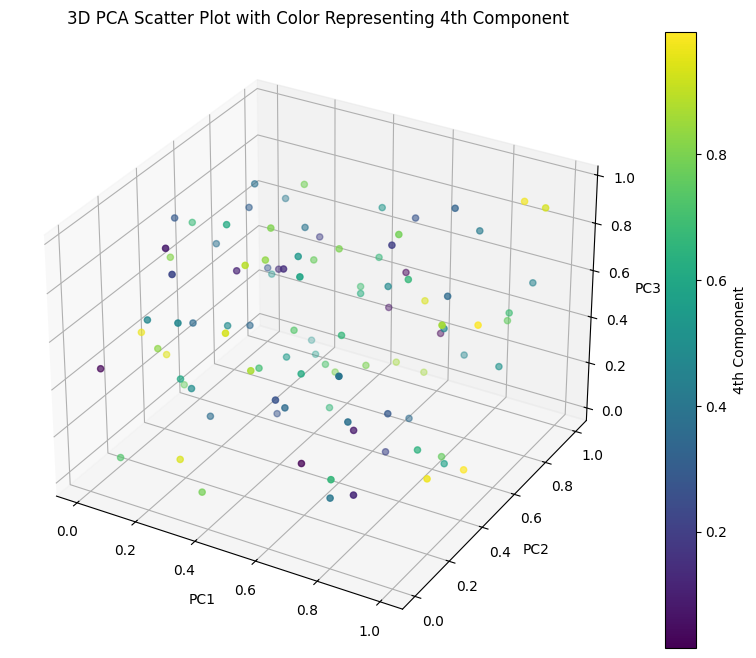

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

artist_short = ['AB', 'MJ', 'KK', 'INA', 'MB', 'ML']

# Example data points (e.g., from PCA)
X1_pca = np.random.rand(100, 4)  # 100 samples, 4 components

# Assuming you want to plot the first 3 components and use the 4th as color
x = X1_pca[:, 0]
y = X1_pca[:, 1]
z = X1_pca[:, 2]
color = X1_pca[:, 3]

# Check if all arrays are of the same length
assert len(x) == len(y) == len(z) == len(color), "Arrays have different lengths"

# 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=color, cmap='viridis')

# Add color bar
fig.colorbar(scatter, label="4th Component")

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title("3D PCA Scatter Plot with Color Representing 4th Component")

plt.show()


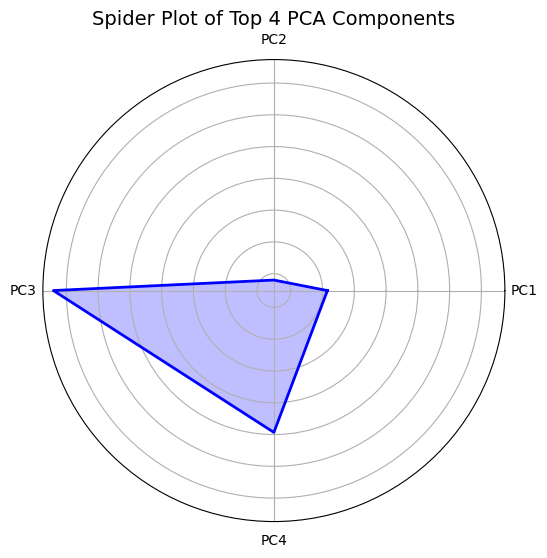

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Sample Data (Replace with your X1 data)
# Assuming X1 has shape (n_samples, n_features)
# X1 = np.random.rand(10, 4)  # 10 samples, 4 components (replace with your data)

# Apply PCA to reduce dimensions (if needed)
pca = PCA(n_components=4)
X1_pca = pca.fit_transform(X2)

# Select the first sample's PCA components for the spider plot
sample_data = X1_pca[0, :4]  # Using the first sample's 4 components

# Labels for the 4 components
labels = ['PC1', 'PC2', 'PC3', 'PC4']

# Number of variables (4 components in this case)
num_vars = len(labels)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot should be closed by repeating the first value at the end
sample_data = np.concatenate((sample_data,[sample_data[0]]))
angles += angles[:1]  # Repeat the first angle to close the plot

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot the data on the spider plot
ax.plot(angles, sample_data, linewidth=2, linestyle='solid', label="Sample Data", color='blue')

# Fill the area under the line
ax.fill(angles, sample_data, alpha=0.25, color='blue')

# Set the labels
ax.set_yticklabels([])  # Hide the radial ticks

# Set the labels for each axis (component names)
ax.set_xticks(angles[:-1])  # Remove the last angle to prevent overlap
ax.set_xticklabels(labels)

# Set the title of the plot
ax.set_title("Spider Plot of Top 4 PCA Components", size=14)

# Display the plot
plt.show()
